In [1]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.spatial.distance import cdist

# System Definitions
A_true = np.array([[0.785, -0.260], [-0.260, 0.315]])
B_true = np.array([[1.475], [0.607]])
A_hat = np.array([[0.700, -0.306], [-0.306, 0.342]])
B_hat = np.array([[1.543], [0.524]])
Q = np.eye(2)
R = np.array([[1]])
z0 = np.array([[1.0], [1.0]])

# LQR Cost Function
def lqr_cost(A, B, K, Q, R, z0, steps=20):
    cost = 0.0
    A_cl = A - B @ K
    z = z0
    for _ in range(steps):
        cost += float(z.T @ (Q + K.T @ R @ K) @ z)
        z = A_cl @ z
    return cost

# Grid Setup
x1_range = np.linspace(-0.5, 4.5, 26)
x2_range = np.linspace(-3.5, 1.5, 26)
X1, X2 = np.meshgrid(x1_range, x2_range)
grid_points = np.c_[X1.ravel(), X2.ravel()]

def eval_log_costs(A, B, points):
    return np.array([np.log(lqr_cost(A, B, k.reshape(1, -1), Q, R, z0)) for k in points])

# Initial Safe Points
fL_values = eval_log_costs(A_hat, B_hat, grid_points)
safe_indices = np.argsort(fL_values)[:3]
safe_points = grid_points[safe_indices]
f_values_safe = eval_log_costs(A_true, B_true, safe_points)

# SAFESLOPE Parameters
max_iters = 150
h = 0.5
beta = 2.0
true_opt_value = np.min(eval_log_costs(A_true, B_true, grid_points))
kernel = C(1.0, (1e-3, 1e3)) * Matern(nu=2.5) + WhiteKernel(noise_level=1e-4)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)

# SAFESLOPE Loop
safe_set = safe_points.copy()
safe_values = f_values_safe.copy()
cumulative_regret = []
cumulative_unsafe = []
searched_points = []

for t in range(max_iters):
    gp.fit(safe_set, safe_values)
    mu, sigma = gp.predict(grid_points, return_std=True)
    lower = mu - np.sqrt(beta) * sigma
    upper = mu + np.sqrt(beta) * sigma

    # Safe expansion using local slope estimates
    expanded_safe_mask = np.full(len(grid_points), False)
    for i, x in enumerate(grid_points):
        for xj in safe_set:
            direction = x - xj
            norm_dir = np.linalg.norm(direction)
            if norm_dir == 0:
                continue
            unit_dir = direction / norm_dir

            # Finite difference estimate of slope along this direction
            x_proj = xj + 0.1 * unit_dir
            if np.any(x_proj < [x1_range[0], x2_range[0]]) or np.any(x_proj > [x1_range[-1], x2_range[-1]]):
                continue
            f_proj = np.log(lqr_cost(A_true, B_true, x_proj.reshape(1, -1), Q, R, z0))
            slope_est = (f_proj - eval_log_costs(A_true, B_true, [xj])[0]) / 0.1

            # Use slope to estimate upper bound at x
            f_xj_upper = upper[np.argmin(np.linalg.norm(grid_points - xj, axis=1))]
            predicted_upper = f_xj_upper + slope_est * norm_dir

            if predicted_upper <= h:
                expanded_safe_mask[i] = True
                
                break
    
    safe_candidates = grid_points[expanded_safe_mask]

    if len(safe_candidates) == 0:
        break

    width = upper[expanded_safe_mask] - lower[expanded_safe_mask]
    idx = np.argmax(width)
    x_next = safe_candidates[idx].reshape(1, -1)

    true_val = np.log(lqr_cost(A_true, B_true, x_next.reshape(1, -1), Q, R, z0))
    searched_points.append(x_next.flatten())

    if true_val <= h:
        safe_set = np.vstack([safe_set, x_next])
        safe_values = np.append(safe_values, true_val)
        cumulative_unsafe.append(cumulative_unsafe[-1] if cumulative_unsafe else 0)
    else:
        cumulative_unsafe.append((cumulative_unsafe[-1] if cumulative_unsafe else 0) + 1)

    regret = true_val - true_opt_value
    cumulative_regret.append((cumulative_regret[-1] if cumulative_regret else 0) + regret)

searched_points = np.array(searched_points)

C:\Users\toazb\AppData\Local\Temp\ipykernel_8808\1548828334.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost += float(z.T @ (Q + K.T @ R @ K) @ z)
c:\Users\toazb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\toazb\AppData\Local\Temp\ipykernel_8808\1548828334.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost += float(z.T @ (Q + K.T @ R @ K) @

In [2]:
print(grid_points)
print(searched_points[75])

[[-0.5 -3.5]
 [-0.3 -3.5]
 [-0.1 -3.5]
 ...
 [ 4.1  1.5]
 [ 4.3  1.5]
 [ 4.5  1.5]]
[ 4.5 -3.3]


C:\Users\toazb\AppData\Local\Temp\ipykernel_8808\2319926147.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


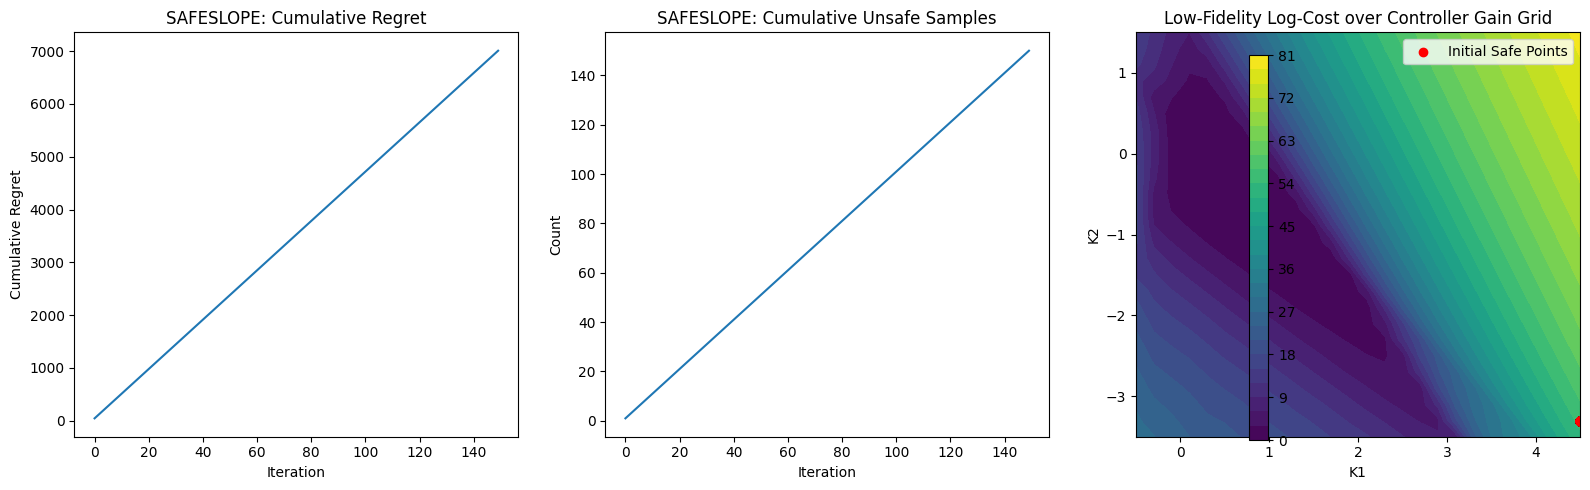

In [3]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(cumulative_regret)
axs[0].set_title("SAFESLOPE: Cumulative Regret")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Cumulative Regret")

axs[1].plot(cumulative_unsafe)
axs[1].set_title("SAFESLOPE: Cumulative Unsafe Samples")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Count")

cs = axs[2].contourf(X1, X2, fL_values.reshape(X1.shape), levels=30)
axs[2].scatter(searched_points[:, 0], searched_points[:, 1], color='red', label='Initial Safe Points')
axs[2].set_title('Low-Fidelity Log-Cost over Controller Gain Grid')
axs[2].set_xlabel('K1')
axs[2].set_ylabel('K2')
axs[2].legend()
fig.colorbar(cs, ax=axs)
plt.tight_layout()
plt.show()